 # Chicago Health Equity Index: Data Engineering
   * Data is collected at the census tract level where possible. Various data features can be grouped into the following catagories: **Economic, Transportation, Education, and Safety**
   * Response feature is csv extract from the CDC: https://www.cdc.gov/nchs/data-visualization/life-expectancy/index.html# 
   * Model features are called via US Census API and SOCRATA API via City of Chicago Data Portal

   * Census data collected from the API of the ACS 5 year from 2015 at the data profile level: Data Dictionary can be found here: https://api.census.gov/data/2015/acs/acs5/profile/variables.html

   * Additional Census Data can be added from the detailed tables here: https://www.census.gov/data/developers/data-sets/acs-5year.html
        * **Detailed Tables** contain the most detailed cross-tabulations, many of which are published down to block groups. The data are population counts. There are over 20,000 variables in this dataset.
        * **Subject Tables** provide an overview of the estimates available in a particular topic.  The data are presented as population counts and percentages.  There are over 18,000 variables in this dataset. 
        * **Data Profiles** contain broad social, economic, housing, and demographic information. The data are presented as population counts and percentages. There are over 1,000 variables in this dataset.
        * **Comparison Profiles** are similar to Data Profiles but also include comparisons with past-year data.  The current year data are compared with prior 5-Year data and include statistical significance testing.  There are over 1,000 variables in this dataset.

## Import Libraries, Functions, and Flat Files

In [241]:
#Import Libraries
#!pip install census
#!pip install us
#!pip install sodapy
#!pip install seaborn
#!pip install --upgrade numpy seaborn
from secrets import *
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from census import Census
from us import states
from datetime import datetime
from sodapy import Socrata

In [242]:
#Import Flat Files
life_expectancy = pd.read_csv('LifeExp.csv')
chicago_tracts=pd.read_csv('Chicago_Tracts.csv')

In [244]:
#Define API Call Functions

    #Chicago Constants
chicago_url='data.cityofchicago.org'
cdp=Socrata(chicago_url, cdp_key)

def callCDP(root: str, filter: str) -> pd.DataFrame:
    results = cdp.get(root, query=filter)
    df=pd.DataFrame.from_records(results)
    return df


def get_census_dp(variables,year=2015):
    c=Census(census_key, year=year)
    # Get the ACS data
    variable_codes=list(variables.values())
    variable_codes.append('NAME')
    data = c.acs5dp.state_county_tract(variable_codes, states.IL.fips, '031', Census.ALL)
    
    # Convert to DataFrame
    census_df = pd.DataFrame(data)
    census_df['tract']=census_df['tract'].astype(int)
    census_df['tract']=census_df['tract'].astype(str)
    
    # Rename columns based on the variable_map keys
    reverse_map = {v: k for k, v in variables.items()}  # Reverse the mapping for renaming
    census_df.rename(columns=reverse_map, inplace=True)

    return census_df

def get_census_dt(variable_codes):
    # Get the ACS data
    variable_codes.append('NAME')
    data = c.acs5.state_county_tract(variable_codes, states.IL.fips, '031', Census.ALL)
    
    # Convert to DataFrame
    census_df = pd.DataFrame(data)
    census_df['tract']=census_df['tract'].astype(int)
    census_df['tract']=census_df['tract'].astype(str)
    
    return census_df

In [245]:
# Example usage
variables= {
    'Insured_Pe': 'DP03_0096PE',
    'NonInsured_Pe': 'DP03_0099PE'
}

df_test=get_census_dp(variables)
df_test.head()

,Insured_Pe,NonInsured_Pe,NAME,state,county,tract
0,86.2,13.8,"Census Tract 2714, Cook County, Illinois",17,031,271400
1,96.4,3.6,"Census Tract 2801, Cook County, Illinois",17,031,280100
2,83.2,16.8,"Census Tract 8235, Cook County, Illinois",17,031,823500
3,86.5,13.5,"Census Tract 8215, Cook County, Illinois",17,031,821500
4,94.2,5.8,"Census Tract 8218, Cook County, Illinois",17,031,821800


## Response Variables: Length of Life and Quality of Life

In [246]:
life_expectancy = life_expectancy[(life_expectancy['State'] == 'Illinois') & (life_expectancy['County'].str.contains('Cook'))]

In [247]:
life_expectancy['Tract'] = life_expectancy['Census Tract Number']
life_expectancy['Tract'] = life_expectancy['Tract']*100
life_expectancy['tract'] = life_expectancy['Tract'].astype(int).astype(str)
life_expectancy.head()

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error,Tract,tract
21114,Illinois,"Cook County, IL",101.00,68.8,56.9-75.1,1.7306,10100.0,10100
21115,Illinois,"Cook County, IL",102.01,77.3,75.2-77.5,1.9253,10201.0,10201
21116,Illinois,"Cook County, IL",102.02,78.6,77.6-79.5,1.3567,10202.0,10202
21117,Illinois,"Cook County, IL",103.00,70.0,56.9-75.1,1.0274,10300.0,10300
21118,Illinois,"Cook County, IL",104.00,79.7,79.6-81.6,1.9647,10400.0,10400


### Filter Response to Only Chicago Tracts

In [248]:
chicago_tracts['tract']=chicago_tracts['TRACTCE10']
chicago_tracts['tract']=chicago_tracts['tract'].astype(str)

In [249]:
life_expectancy = pd.merge(life_expectancy,chicago_tracts, on='tract', how='inner')
life_expectancy.head()

,State,County,Census Tract Number,Life Expectancy,Life Expectancy Range,Life Expectancy Standard Error,Tract,tract,geometry_,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,NAMELSAD10,commarea,neighborhood
0,Illinois,"Cook County, IL",101.00,68.8,56.9-75.1,1.7306,10100.0,10100,MULTIPOLYGON (((-87.66368000002299 42.01939800...,17,31,10100,17031010100,101.00,Census Tract 101,1,ROGERS PARK
1,Illinois,"Cook County, IL",102.01,77.3,75.2-77.5,1.9253,10201.0,10201,MULTIPOLYGON (((-87.6800950000417 42.012537999...,17,31,10201,17031010201,102.01,Census Tract 102.01,1,ROGERS PARK
2,Illinois,"Cook County, IL",102.02,78.6,77.6-79.5,1.3567,10202.0,10202,MULTIPOLYGON (((-87.67335799998422 42.01937400...,17,31,10202,17031010202,102.02,Census Tract 102.02,1,ROGERS PARK
3,Illinois,"Cook County, IL",103.00,70.0,56.9-75.1,1.0274,10300.0,10300,MULTIPOLYGON (((-87.66505999995483 42.01280100...,17,31,10300,17031010300,103.00,Census Tract 103,1,ROGERS PARK
4,Illinois,"Cook County, IL",104.00,79.7,79.6-81.6,1.9647,10400.0,10400,MULTIPOLYGON (((-87.65080299995667 41.99848500...,17,31,10400,17031010400,104.00,Census Tract 104,1,ROGERS PARK


### Test Join on Tract Level

In [250]:
merge_df=pd.merge(df_test, life_expectancy, on='tract', how='inner')
merge_df.head()

,Insured_Pe,NonInsured_Pe,NAME,state,county,tract,State,County,Census Tract Number,Life Expectancy,...,Tract,geometry_,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,NAMELSAD10,commarea,neighborhood
0,86.2,13.8,"Census Tract 2714, Cook County, Illinois",17,031,271400,Illinois,"Cook County, IL",2714.0,68.6,...,271400.0,MULTIPOLYGON (((-87.71080299996187 41.87426299...,17,31,271400,17031271400,2714.0,Census Tract 2714,27,EAST GARFIELD PARK
1,96.4,3.6,"Census Tract 2801, Cook County, Illinois",17,031,280100,Illinois,"Cook County, IL",2801.0,NaN,...,280100.0,MULTIPOLYGON (((-87.64571900003747 41.88179600...,17,31,280100,17031280100,2801.0,Census Tract 2801,28,NEAR WEST SIDE
2,68.6,31.4,"Census Tract 3103, Cook County, Illinois",17,031,310300,Illinois,"Cook County, IL",3103.0,79.1,...,310300.0,MULTIPOLYGON (((-87.64926400002443 41.85259500...,17,31,310300,17031310300,3103.0,Census Tract 3103,31,LOWER WEST SIDE
3,78.1,21.9,"Census Tract 2002, Cook County, Illinois",17,031,200200,Illinois,"Cook County, IL",2002.0,78.5,...,200200.0,MULTIPOLYGON (((-87.74165199997601 41.93159800...,17,31,200200,17031200200,2002.0,Census Tract 2002,20,HERMOSA
4,75.8,24.2,"Census Tract 2214, Cook County, Illinois",17,031,221400,Illinois,"Cook County, IL",2214.0,80.9,...,221400.0,MULTIPOLYGON (((-87.69738199997865 41.92358800...,17,31,221400,17031221400,2214.0,Census Tract 2214,22,LOGAN SQUARE


## Feature List

In [251]:
features= {
'Population': 'DP05_0001E',
'Poverty': 'DP03_0119PE',
'Income': 'DP03_0066E',
'Unemployment': 'DP03_0009PE',
'Education': 'DP02_0066PE',
'Healthcare': 'DP03_0099PE',
'Insurance': 'DP03_0096PE',
}

In [252]:
features = {
    'Labor Force': 'DP03_0002E',  # Population 16+ in labor force
    'Unemployed': 'DP03_0005PE',  # %Unemployed population 16+ in civilian labor force
    'Family Poverty': 'DP03_0119PE',  # % Families below poverty level
    'HS Graduates': 'DP02_0061PE',  # % Population 25+ with high school diploma
    'Bachelors Degree': 'DP02_0064PE',  # % Population 25+ with bachelor's degree
    'Grad/Prof Degree': 'DP02_0065PE',  # % Population 25+ with graduate or professional degree
    'Private Health Ins': 'DP03_0097PE',  # % Population with private health insurance
    'Public Health Ins': 'DP03_0098PE',  # % Population with public health insurance
    'No Health Ins': 'DP03_0099PE',  # % Population without health insurance
    'No Vehicles': 'DP04_0058PE',  # % % Households with no vehicles
    'One Vehicle': 'DP04_0059PE',  # % Households with 1 vehicle
    'Two Vehicles': 'DP04_0060PE',  # % Households with 2 vehicles
    'Three+ Vehicles': 'DP04_0061PE',  # % Households with 3+ vehicles
    'Drive Alone': 'DP03_0019PE',  # % Commute by driving alone
    'Carpooled': 'DP03_0020PE',  #  % Commute by carpooling
    'Walked': 'DP03_0022PE', #% commute by walking
    'Other means': 'DP03_0023PE', # % commute by other means
    'WFH': 'DP03_0024PE', # % WFH
    'Public Transit': 'DP03_0021PE',  # % Commute by public transportation
    'Total Population': 'DP02_0122E',  # Total population by ancestry
    'Male':'DP05_0002PE', #% of Population Male
    'Female':'DP05_0003PE' #% of Population Female 
}


## Call API Data

In [253]:
features_df=get_census_dp(features)
features_df.head()

,Labor Force,Unemployed,Family Poverty,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,Public Health Ins,No Health Ins,No Vehicles,...,Other means,WFH,Public Transit,Total Population,Male,Female,NAME,state,county,tract
0,456.0,8.5,43.3,26.0,11.0,3.0,30.1,58.8,13.8,30.2,...,7.8,11.2,41.2,1185.0,51.9,48.1,"Census Tract 2714, Cook County, Illinois",17,031,271400
1,5892.0,2.7,0.0,3.8,49.4,39.9,94.5,4.7,3.6,31.0,...,6.1,7.3,14.1,6811.0,49.3,50.7,"Census Tract 2801, Cook County, Illinois",17,031,280100
2,2447.0,11.3,13.3,35.4,12.1,9.6,57.2,36.8,16.8,11.0,...,1.4,0.3,8.8,4643.0,49.7,50.3,"Census Tract 8235, Cook County, Illinois",17,031,823500
3,812.0,12.6,27.4,35.2,8.8,2.7,39.2,54.4,13.5,24.9,...,0.0,7.1,20.8,1858.0,43.1,56.9,"Census Tract 8215, Cook County, Illinois",17,031,821500
4,3100.0,7.3,4.5,26.8,19.9,12.1,83.1,20.0,5.8,8.8,...,0.8,1.9,10.0,5369.0,46.8,53.2,"Census Tract 8218, Cook County, Illinois",17,031,821800


## Joined Model and Export

In [254]:
#merge
model=pd.merge(features_df, life_expectancy, on='tract', how='inner')
model.head()

,Labor Force,Unemployed,Family Poverty,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,Public Health Ins,No Health Ins,No Vehicles,...,Tract,geometry_,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,NAMELSAD10,commarea,neighborhood
0,456.0,8.5,43.3,26.0,11.0,3.0,30.1,58.8,13.8,30.2,...,271400.0,MULTIPOLYGON (((-87.71080299996187 41.87426299...,17,31,271400,17031271400,2714.0,Census Tract 2714,27,EAST GARFIELD PARK
1,5892.0,2.7,0.0,3.8,49.4,39.9,94.5,4.7,3.6,31.0,...,280100.0,MULTIPOLYGON (((-87.64571900003747 41.88179600...,17,31,280100,17031280100,2801.0,Census Tract 2801,28,NEAR WEST SIDE
2,1126.0,11.1,14.2,15.6,26.3,11.7,49.5,23.8,31.4,21.7,...,310300.0,MULTIPOLYGON (((-87.64926400002443 41.85259500...,17,31,310300,17031310300,3103.0,Census Tract 3103,31,LOWER WEST SIDE
3,2440.0,7.4,26.9,34.6,6.8,2.6,32.8,49.0,21.9,24.7,...,200200.0,MULTIPOLYGON (((-87.74165199997601 41.93159800...,17,31,200200,17031200200,2002.0,Census Tract 2002,20,HERMOSA
4,2048.0,2.9,12.7,22.6,29.6,14.7,63.7,14.8,24.2,22.0,...,221400.0,MULTIPOLYGON (((-87.69738199997865 41.92358800...,17,31,221400,17031221400,2214.0,Census Tract 2214,22,LOGAN SQUARE


In [255]:
#export
final_model=model
final_model.to_csv('final_model.csv')

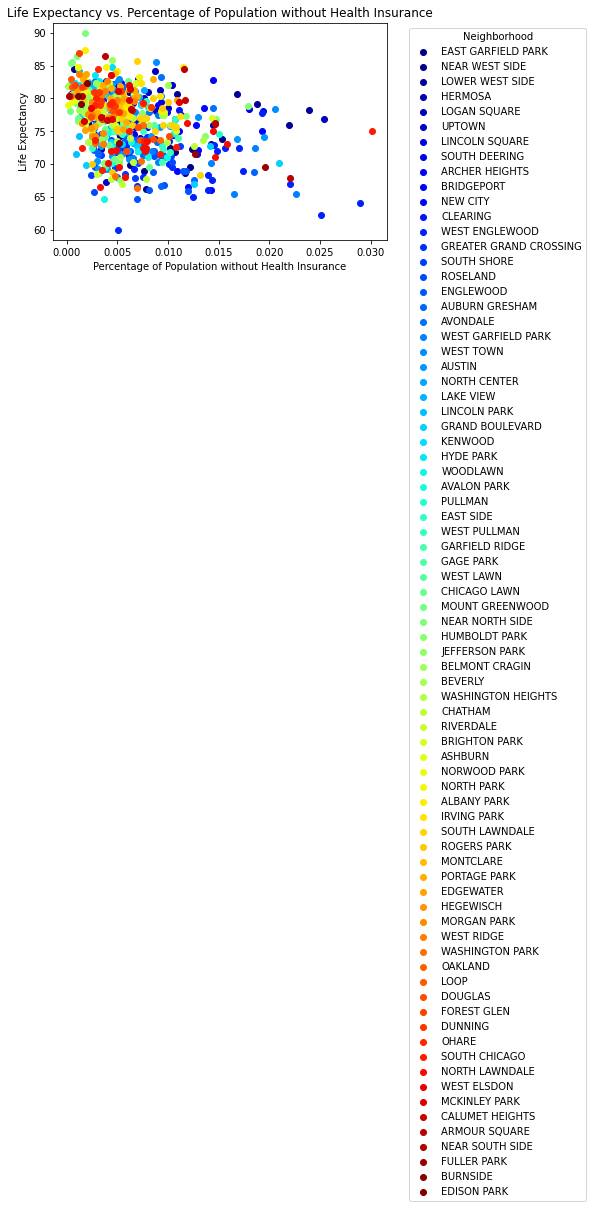

In [256]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'Neighborhood' is a column in your final_model DataFrame
# and it contains categorical data representing different neighborhoods

# Map each unique neighborhood to a color
unique_neighborhoods = final_model['neighborhood'].unique()
colors = plt.cm.jet(np.linspace(0, 1, len(unique_neighborhoods)))
neighborhood_colors = {neighborhood: color for neighborhood, color in zip(unique_neighborhoods, colors)}

# Scatter plot
for neighborhood in unique_neighborhoods:
    subset = final_model[final_model['neighborhood'] == neighborhood]
    plt.scatter(subset['No Health Ins'] / subset['Total Population'], subset['Life Expectancy'], 
                color=neighborhood_colors[neighborhood], label=neighborhood)

plt.xlabel('Percentage of Population without Health Insurance')
plt.ylabel('Life Expectancy')
plt.title('Life Expectancy vs. Percentage of Population without Health Insurance')
plt.legend(title='Neighborhood', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.show()


In [257]:
model.describe()

,Labor Force,Unemployed,Family Poverty,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,Public Health Ins,No Health Ins,No Vehicles,...,Census Tract Number,Life Expectancy,Life Expectancy Standard Error,Tract,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,commarea
count,800.000000,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,8.000000e+02,...,800.000000,701.000000,701.000000,800.000000,800.0,800.0,800.000000,8.000000e+02,800.000000,800.000000
mean,1819.951250,-2.499991e+06,-2.499980e+06,-2.499976e+06,-2.499980e+06,-2.499987e+06,-2.499947e+06,-2.499964e+06,-2.499984e+06,-2.499973e+06,...,4058.249075,76.621826,2.158328,405824.907500,17.0,31.0,405824.905000,1.703141e+10,4058.249050,34.946250
std,1108.278481,4.077370e+07,4.077370e+07,4.077370e+07,4.077370e+07,4.077370e+07,4.077371e+07,4.077370e+07,4.077370e+07,4.077370e+07,...,2778.272753,4.666589,0.704843,277827.275273,0.0,0.0,277827.278655,2.778273e+05,2778.272787,22.761832
min,0.000000,-6.666667e+08,-6.666667e+08,-6.666667e+08,-6.666667e+08,-6.666667e+08,-6.666667e+08,-6.666667e+08,-6.666667e+08,-6.666667e+08,...,101.000000,59.900000,0.874700,10100.000000,17.0,31.0,10100.000000,1.703101e+10,101.000000,1.000000
25%,991.500000,4.800000e+00,7.100000e+00,1.527500e+01,7.800000e+00,3.475000e+00,3.357500e+01,2.255000e+01,9.900000e+00,1.497500e+01,...,1609.750000,73.300000,1.618200,160975.000000,17.0,31.0,160975.000000,1.703116e+10,1609.750000,16.000000
50%,1666.000000,7.600000e+00,1.750000e+01,2.610000e+01,1.490000e+01,8.400000e+00,5.060000e+01,3.685000e+01,1.620000e+01,2.455000e+01,...,3558.500000,77.200000,2.023500,355850.000000,17.0,31.0,355850.000000,1.703136e+10,3558.500000,29.000000
75%,2457.250000,1.150000e+01,2.950000e+01,3.302500e+01,2.845000e+01,2.022500e+01,7.275000e+01,4.920000e+01,2.220000e+01,3.712500e+01,...,6704.250000,80.300000,2.581000,670425.000000,17.0,31.0,670425.000000,1.703167e+10,6704.250000,56.000000
max,12810.000000,5.900000e+01,7.230000e+01,5.630000e+01,6.650000e+01,7.490000e+01,9.690000e+01,7.840000e+01,4.500000e+01,7.470000e+01,...,9801.000000,90.000000,3.947000,980100.000000,17.0,31.0,980100.000000,1.703198e+10,9801.000000,77.000000


In [258]:
model.columns

Index(['Labor Force', 'Unemployed', 'Family Poverty', 'HS Graduates',
       'Bachelors Degree', 'Grad/Prof Degree', 'Private Health Ins',
       'Public Health Ins', 'No Health Ins', 'No Vehicles', 'One Vehicle',
       'Two Vehicles', 'Three+ Vehicles', 'Drive Alone', 'Carpooled', 'Walked',
       'Other means', 'WFH', 'Public Transit', 'Total Population', 'Male',
       'Female', 'NAME', 'state', 'county', 'tract', 'State', 'County',
       'Census Tract Number', 'Life Expectancy', 'Life Expectancy Range',
       'Life Expectancy Standard Error', 'Tract', 'geometry_', 'STATEFP10',
       'COUNTYFP10', 'TRACTCE10', 'geoid', 'NAME10', 'NAMELSAD10', 'commarea',
       'neighborhood'],
      dtype='object')

In [259]:
model.info

<bound method DataFrame.info of      Labor Force  Unemployed  Family Poverty  HS Graduates  Bachelors Degree  \
0          456.0         8.5            43.3          26.0              11.0   
1         5892.0         2.7             0.0           3.8              49.4   
2         1126.0        11.1            14.2          15.6              26.3   
3         2440.0         7.4            26.9          34.6               6.8   
4         2048.0         2.9            12.7          22.6              29.6   
..           ...         ...             ...           ...               ...   
795       2670.0         2.3             4.0           3.4              54.4   
796       4113.0         6.9             7.6          18.7              27.2   
797       2412.0         7.7            19.9          19.5              25.9   
798       2800.0         5.1             2.5           8.7              36.6   
799       1714.0         7.1             5.2          15.1              27.4   

     Gr

## Unemployment Category

In [260]:

def categorize_unemployment_percentage(percentage):
    if percentage <= 5:
        return 'less than 5%'
    elif 5 < percentage <= 10:
        return '5-10%'
    elif 10 < percentage <= 15:
        return '10-15%'
    elif 15 < percentage <= 20:
        return '15-20%'
    elif 20 < percentage <= 25:
        return '20-25%'
    else:
        return '25 or more'


model['Unemployed_cat'] = model['Unemployed'].apply(categorize_unemployment_percentage)

In [261]:
print(model['Unemployed_cat'].describe())
model.head()

count       800
unique        6
top       5-10%
freq        322
Name: Unemployed_cat, dtype: object


,Labor Force,Unemployed,Family Poverty,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,Public Health Ins,No Health Ins,No Vehicles,...,geometry_,STATEFP10,COUNTYFP10,TRACTCE10,geoid,NAME10,NAMELSAD10,commarea,neighborhood,Unemployed_cat
0,456.0,8.5,43.3,26.0,11.0,3.0,30.1,58.8,13.8,30.2,...,MULTIPOLYGON (((-87.71080299996187 41.87426299...,17,31,271400,17031271400,2714.0,Census Tract 2714,27,EAST GARFIELD PARK,5-10%
1,5892.0,2.7,0.0,3.8,49.4,39.9,94.5,4.7,3.6,31.0,...,MULTIPOLYGON (((-87.64571900003747 41.88179600...,17,31,280100,17031280100,2801.0,Census Tract 2801,28,NEAR WEST SIDE,less than 5%
2,1126.0,11.1,14.2,15.6,26.3,11.7,49.5,23.8,31.4,21.7,...,MULTIPOLYGON (((-87.64926400002443 41.85259500...,17,31,310300,17031310300,3103.0,Census Tract 3103,31,LOWER WEST SIDE,10-15%
3,2440.0,7.4,26.9,34.6,6.8,2.6,32.8,49.0,21.9,24.7,...,MULTIPOLYGON (((-87.74165199997601 41.93159800...,17,31,200200,17031200200,2002.0,Census Tract 2002,20,HERMOSA,5-10%
4,2048.0,2.9,12.7,22.6,29.6,14.7,63.7,14.8,24.2,22.0,...,MULTIPOLYGON (((-87.69738199997865 41.92358800...,17,31,221400,17031221400,2214.0,Census Tract 2214,22,LOGAN SQUARE,less than 5%


# Sex Category

In [262]:

def categorize_sex_percentage(percentage):
    if percentage < 50:
        return 'More Men'
    else:
        return 'More Women'

model['sex_cat'] = model['Female'].apply(categorize_sex_percentage)


In [263]:
model['sex_cat'].describe()


count            800
unique             2
top       More Women
freq             528
Name: sex_cat, dtype: object

In [264]:

def get_max_category(row):
    vehicle_categories = ['No Vehicles', 'One Vehicle', 'Two Vehicles', 'Three+ Vehicles']
    max_category = max(vehicle_categories, key=lambda x: row[x])
    return max_category

model['vehicle_cat'] = model.apply(get_max_category, axis=1)

print(model[['No Vehicles', 'One Vehicle', 'Two Vehicles', 'Three+ Vehicles', 'vehicle_cat']])


     No Vehicles  One Vehicle  Two Vehicles  Three+ Vehicles  vehicle_cat
0           30.2         54.2          15.1              0.5  One Vehicle
1           31.0         58.1           9.5              1.3  One Vehicle
2           21.7         37.6          30.5             10.2  One Vehicle
3           24.7         32.6          30.3             12.3  One Vehicle
4           22.0         60.7          15.3              2.0  One Vehicle
..           ...          ...           ...              ...          ...
795         21.9         57.6          16.3              4.2  One Vehicle
796         34.7         53.3          11.4              0.5  One Vehicle
797         16.8         50.8          29.8              2.6  One Vehicle
798         20.5         58.7          17.2              3.6  One Vehicle
799          8.4         43.1          33.7             14.8  One Vehicle

[800 rows x 5 columns]


In [265]:
model['vehicle_cat'].describe()

count             800
unique              4
top       One Vehicle
freq              576
Name: vehicle_cat, dtype: object

## Mode of transportation category

In [266]:

def get_max_transport_mode(row):
    transport_modes = ['Drive Alone', 'Carpooled', 'Walked', 'Other means', 'WFH', 'Public Transit']
    max_mode = max(transport_modes, key=lambda x: row[x])
    return max_mode


model['transport_cat'] = model.apply(get_max_transport_mode, axis=1)

print(model[['Drive Alone', 'Carpooled', 'Walked', 'Other means', 'WFH', 'Public Transit', 'transport_cat']])


     Drive Alone  Carpooled  Walked  Other means   WFH  Public Transit  \
0           31.0        8.3     0.5          7.8  11.2            41.2   
1           25.4        3.5    43.6          6.1   7.3            14.1   
2           51.7        5.7     5.5         10.8   3.6            22.6   
3           66.0        8.9     4.1          1.6   2.0            17.4   
4           38.8        5.7     0.3          4.4   9.6            41.2   
..           ...        ...     ...          ...   ...             ...   
795         31.7        2.6    10.2          2.3   3.6            49.5   
796         33.3        5.1     8.4          4.1   3.6            45.5   
797         60.9        8.0     5.0          3.0   2.1            21.1   
798         38.9        7.5     4.2          5.9   8.2            35.4   
799         64.8        8.9     3.0          1.3   3.8            18.3   

      transport_cat  
0    Public Transit  
1            Walked  
2       Drive Alone  
3       Drive Alone  
4

In [267]:
model['transport_cat'].describe()


count             800
unique              4
top       Drive Alone
freq              623
Name: transport_cat, dtype: object

In [268]:
model.head()

,Labor Force,Unemployed,Family Poverty,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,Public Health Ins,No Health Ins,No Vehicles,...,TRACTCE10,geoid,NAME10,NAMELSAD10,commarea,neighborhood,Unemployed_cat,sex_cat,vehicle_cat,transport_cat
0,456.0,8.5,43.3,26.0,11.0,3.0,30.1,58.8,13.8,30.2,...,271400,17031271400,2714.0,Census Tract 2714,27,EAST GARFIELD PARK,5-10%,More Men,One Vehicle,Public Transit
1,5892.0,2.7,0.0,3.8,49.4,39.9,94.5,4.7,3.6,31.0,...,280100,17031280100,2801.0,Census Tract 2801,28,NEAR WEST SIDE,less than 5%,More Women,One Vehicle,Walked
2,1126.0,11.1,14.2,15.6,26.3,11.7,49.5,23.8,31.4,21.7,...,310300,17031310300,3103.0,Census Tract 3103,31,LOWER WEST SIDE,10-15%,More Men,One Vehicle,Drive Alone
3,2440.0,7.4,26.9,34.6,6.8,2.6,32.8,49.0,21.9,24.7,...,200200,17031200200,2002.0,Census Tract 2002,20,HERMOSA,5-10%,More Men,One Vehicle,Drive Alone
4,2048.0,2.9,12.7,22.6,29.6,14.7,63.7,14.8,24.2,22.0,...,221400,17031221400,2214.0,Census Tract 2214,22,LOGAN SQUARE,less than 5%,More Men,One Vehicle,Public Transit


## Education Category

In [269]:

def get_max_education_level(row):
    education_levels = ['HS Graduates', 'Bachelors Degree', 'Grad/Prof Degree']
    max_level = max(education_levels, key=lambda x: row[x])
    return max_level

model['education_cat'] = model.apply(get_max_education_level, axis=1)

print(model[['HS Graduates', 'Bachelors Degree', 'Grad/Prof Degree', 'education_cat']])


     HS Graduates  Bachelors Degree  Grad/Prof Degree     education_cat
0            26.0              11.0               3.0      HS Graduates
1             3.8              49.4              39.9  Bachelors Degree
2            15.6              26.3              11.7  Bachelors Degree
3            34.6               6.8               2.6      HS Graduates
4            22.6              29.6              14.7  Bachelors Degree
..            ...               ...               ...               ...
795           3.4              54.4              35.6  Bachelors Degree
796          18.7              27.2              18.6  Bachelors Degree
797          19.5              25.9              16.6  Bachelors Degree
798           8.7              36.6              31.5  Bachelors Degree
799          15.1              27.4              23.9  Bachelors Degree

[800 rows x 4 columns]


In [270]:
model['education_cat'].describe()

count              800
unique               3
top       HS Graduates
freq               513
Name: education_cat, dtype: object

## Health Insurance Category

In [271]:

def get_max_health_insurance(row):
    health_insurance_categories = ['Private Health Ins', 'Public Health Ins', 'No Health Ins']
    max_category = max(health_insurance_categories, key=lambda x: row[x])
    return max_category

# Apply the function to each row and create a new column
model['health_ins_cat'] = model.apply(get_max_health_insurance, axis=1)

print(model[['Private Health Ins', 'Public Health Ins', 'No Health Ins', 'health_ins_cat']])


     Private Health Ins  Public Health Ins  No Health Ins      health_ins_cat
0                  30.1               58.8           13.8   Public Health Ins
1                  94.5                4.7            3.6  Private Health Ins
2                  49.5               23.8           31.4  Private Health Ins
3                  32.8               49.0           21.9   Public Health Ins
4                  63.7               14.8           24.2  Private Health Ins
..                  ...                ...            ...                 ...
795                93.1                3.8            5.1  Private Health Ins
796                63.3               19.1           22.3  Private Health Ins
797                51.7               36.9           18.0  Private Health Ins
798                76.6               16.1           13.2  Private Health Ins
799                76.5               21.7           10.1  Private Health Ins

[800 rows x 4 columns]


In [272]:
model.head()


,Labor Force,Unemployed,Family Poverty,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,Public Health Ins,No Health Ins,No Vehicles,...,NAME10,NAMELSAD10,commarea,neighborhood,Unemployed_cat,sex_cat,vehicle_cat,transport_cat,education_cat,health_ins_cat
0,456.0,8.5,43.3,26.0,11.0,3.0,30.1,58.8,13.8,30.2,...,2714.0,Census Tract 2714,27,EAST GARFIELD PARK,5-10%,More Men,One Vehicle,Public Transit,HS Graduates,Public Health Ins
1,5892.0,2.7,0.0,3.8,49.4,39.9,94.5,4.7,3.6,31.0,...,2801.0,Census Tract 2801,28,NEAR WEST SIDE,less than 5%,More Women,One Vehicle,Walked,Bachelors Degree,Private Health Ins
2,1126.0,11.1,14.2,15.6,26.3,11.7,49.5,23.8,31.4,21.7,...,3103.0,Census Tract 3103,31,LOWER WEST SIDE,10-15%,More Men,One Vehicle,Drive Alone,Bachelors Degree,Private Health Ins
3,2440.0,7.4,26.9,34.6,6.8,2.6,32.8,49.0,21.9,24.7,...,2002.0,Census Tract 2002,20,HERMOSA,5-10%,More Men,One Vehicle,Drive Alone,HS Graduates,Public Health Ins
4,2048.0,2.9,12.7,22.6,29.6,14.7,63.7,14.8,24.2,22.0,...,2214.0,Census Tract 2214,22,LOGAN SQUARE,less than 5%,More Men,One Vehicle,Public Transit,Bachelors Degree,Private Health Ins


In [273]:
model.columns


Index(['Labor Force', 'Unemployed', 'Family Poverty', 'HS Graduates',
       'Bachelors Degree', 'Grad/Prof Degree', 'Private Health Ins',
       'Public Health Ins', 'No Health Ins', 'No Vehicles', 'One Vehicle',
       'Two Vehicles', 'Three+ Vehicles', 'Drive Alone', 'Carpooled', 'Walked',
       'Other means', 'WFH', 'Public Transit', 'Total Population', 'Male',
       'Female', 'NAME', 'state', 'county', 'tract', 'State', 'County',
       'Census Tract Number', 'Life Expectancy', 'Life Expectancy Range',
       'Life Expectancy Standard Error', 'Tract', 'geometry_', 'STATEFP10',
       'COUNTYFP10', 'TRACTCE10', 'geoid', 'NAME10', 'NAMELSAD10', 'commarea',
       'neighborhood', 'Unemployed_cat', 'sex_cat', 'vehicle_cat',
       'transport_cat', 'education_cat', 'health_ins_cat'],
      dtype='object')

## Neighborhood Category

In [274]:
neighborhood_groups = {
    'ROGERS PARK': 'Far North Side',
    'WEST RIDGE': 'Far North Side',
    'UPTOWN': 'Far North Side',
    'LINCOLN SQUARE': 'Far North Side',
    'EDISON PARK': 'Far North Side',
    'NORWOOD PARK': 'Far North Side',
    'JEFFERSON PARK': 'Far North Side',
    'FOREST GLEN': 'Far North Side',
    'NORTH PARK': 'Far North Side',
    'ALBANY PARK': 'Far North Side',
    'OHARE': 'Far North Side',
    'EDGEWATER': 'Far North Side',
    'NORTH CENTER': 'North Side',
    'LAKEVIEW': 'North Side',
    'LINCOLN PARK': 'North Side',
    'AVONDALE': 'North Side',
    'LOGAN SQUARE': 'North Side',
    'PORTAGE PARK': 'Northwest Side',
    'IRVING PARK': 'Northwest Side',
    'DUNNING': 'Northwest Side',
    'MONTCLARE': 'Northwest Side',
    'BELMONT CRAGIN': 'Northwest Side',
    'HERMOSA': 'Northwest Side',
    'NEAR NORTH SIDE': 'Central',
    'LOOP': 'Central',
    'NEAR SOUTH SIDE': 'Central',
    'HUMBOLDT PARK': 'West Side',
    'WEST TOWN': 'West Side',
    'AUSTIN': 'West Side',
    'WEST GARFIELD PARK': 'West Side',
    'EAST GARFIELD PARK': 'West Side',
    'NEAR WEST SIDE': 'West Side',
    'NORTH LAWNDALE': 'West Side',
    'SOUTH LAWNDALE': 'West Side',
    'LOWER WEST SIDE': 'West Side',
    'GARFIELD RIDGE': 'Southwest Side',
    'ARCHER HEIGHTS': 'Southwest Side',
    'BRIGHTON PARK': 'Southwest Side',
    'MCKINLEY PARK': 'Southwest Side',
    'NEW CITY': 'Southwest Side',
    'WEST ELSDON': 'Southwest Side',
    'GAGE PARK': 'Southwest Side',
    'CLEARING': 'Southwest Side',
    'WEST LAWN': 'Southwest Side',
    'CHICAGO LAWN': 'Southwest Side',
    'WEST ENGLEWOOD': 'Southwest Side',
    'ENGLEWOOD': 'Southwest Side',
    'ARMOUR SQUARE': 'South Side',
    'DOUGLAS': 'South Side',
    'OAKLAND': 'South Side',
    'FULLER PARK': 'South Side',
    'GRAND BOULEVARD': 'South Side',
    'KENWOOD': 'South Side',
    'WASHINGTON PARK': 'South Side',
    'HYDE PARK': 'South Side',
    'WOODLAWN': 'South Side',
    'SOUTH SHORE': 'South Side',
    'BRIDGEPORT': 'South Side',
    'GREATER GRAND CROSSING': 'South Side',
    'ASHBURN': 'Far Southwest Side',
    'AUBURN GRESHAM': 'Far Southwest Side',
    'BEVERLY': 'Far Southwest Side',
    'WASHINGTON HEIGHTS': 'Far Southwest Side',
    'MOUNT GREENWOOD': 'Far Southwest Side',
    'MORGAN PARK': 'Far Southwest Side',
    'CHATHAM': 'Far South Side',
    'AVALON PARK': 'Far South Side',
    'SOUTH CHICAGO': 'Far South Side',
    'BURNSIDE': 'Far South Side',
    'CALUMET HEIGHTS': 'Far South Side',
    'ROSELAND': 'Far South Side',
    'PULLMAN': 'Far South Side',
    'SOUTH DEERING': 'Far South Side',
    'EAST SIDE': 'Far South Side',
    'WEST PULLMAN': 'Far South Side',
    'RIVERDALE': 'Far South Side',
    'HEGEWISCH': 'Far South Side'
}




In [275]:

model['neighborhood_loc'] = model['neighborhood'].map(neighborhood_groups)

print(model.head())


   Labor Force  Unemployed  Family Poverty  HS Graduates  Bachelors Degree  \
0        456.0         8.5            43.3          26.0              11.0   
1       5892.0         2.7             0.0           3.8              49.4   
2       1126.0        11.1            14.2          15.6              26.3   
3       2440.0         7.4            26.9          34.6               6.8   
4       2048.0         2.9            12.7          22.6              29.6   

   Grad/Prof Degree  Private Health Ins  Public Health Ins  No Health Ins  \
0               3.0                30.1               58.8           13.8   
1              39.9                94.5                4.7            3.6   
2              11.7                49.5               23.8           31.4   
3               2.6                32.8               49.0           21.9   
4              14.7                63.7               14.8           24.2   

   No Vehicles  ...         NAMELSAD10  commarea        neighborhood

## Life Expectancy Category
1 = Observed Life Expectancy is greater than the average 

0 = Observed life Expectancy is lower than the average 

In [276]:
average_life_expectancy = 76.6

def above_average_life_expectancy(row):
    if row['Life Expectancy'] > average_life_expectancy:
        return '1' #1 is Yes LE is greater than the average LE observed
    else:
        return '0' #0 is NO LE is lower than the average LE observed


model['Life Expectancy_abvavg'] = model.apply(above_average_life_expectancy, axis=1)


print(model.head())


   Labor Force  Unemployed  Family Poverty  HS Graduates  Bachelors Degree  \
0        456.0         8.5            43.3          26.0              11.0   
1       5892.0         2.7             0.0           3.8              49.4   
2       1126.0        11.1            14.2          15.6              26.3   
3       2440.0         7.4            26.9          34.6               6.8   
4       2048.0         2.9            12.7          22.6              29.6   

   Grad/Prof Degree  Private Health Ins  Public Health Ins  No Health Ins  \
0               3.0                30.1               58.8           13.8   
1              39.9                94.5                4.7            3.6   
2              11.7                49.5               23.8           31.4   
3               2.6                32.8               49.0           21.9   
4              14.7                63.7               14.8           24.2   

   No Vehicles  ...  commarea        neighborhood  Unemployed_cat   

## Life Expectancy Difference
Difference in observed and average Life Expectancy 

In [277]:

model['Life_Expectancy_Difference'] = model['Life Expectancy'] - average_life_expectancy

print(model.head())


   Labor Force  Unemployed  Family Poverty  HS Graduates  Bachelors Degree  \
0        456.0         8.5            43.3          26.0              11.0   
1       5892.0         2.7             0.0           3.8              49.4   
2       1126.0        11.1            14.2          15.6              26.3   
3       2440.0         7.4            26.9          34.6               6.8   
4       2048.0         2.9            12.7          22.6              29.6   

   Grad/Prof Degree  Private Health Ins  Public Health Ins  No Health Ins  \
0               3.0                30.1               58.8           13.8   
1              39.9                94.5                4.7            3.6   
2              11.7                49.5               23.8           31.4   
3               2.6                32.8               49.0           21.9   
4              14.7                63.7               14.8           24.2   

   No Vehicles  ...        neighborhood  Unemployed_cat     sex_cat 

## One-Hot Encoding of Categoricl Variables 

In [278]:
categorical_columns = ['Unemployed_cat', 'sex_cat', 'vehicle_cat', 'transport_cat', 'education_cat', 'health_ins_cat', 'neighborhood_loc']

encoded_columns = pd.get_dummies(model[categorical_columns], prefix=categorical_columns, prefix_sep='_')

encoded_columns = encoded_columns.apply(lambda x: x.astype(int))

model_1 = pd.concat([model, encoded_columns], axis=1)

model_1.drop(columns=categorical_columns, inplace=True)

print(model_1.head())


   Labor Force  Unemployed  Family Poverty  HS Graduates  Bachelors Degree  \
0        456.0         8.5            43.3          26.0              11.0   
1       5892.0         2.7             0.0           3.8              49.4   
2       1126.0        11.1            14.2          15.6              26.3   
3       2440.0         7.4            26.9          34.6               6.8   
4       2048.0         2.9            12.7          22.6              29.6   

   Grad/Prof Degree  Private Health Ins  Public Health Ins  No Health Ins  \
0               3.0                30.1               58.8           13.8   
1              39.9                94.5                4.7            3.6   
2              11.7                49.5               23.8           31.4   
3               2.6                32.8               49.0           21.9   
4              14.7                63.7               14.8           24.2   

   No Vehicles  ...  health_ins_cat_Public Health Ins  \
0         3

In [279]:
model_1.columns

Index(['Labor Force', 'Unemployed', 'Family Poverty', 'HS Graduates',
       'Bachelors Degree', 'Grad/Prof Degree', 'Private Health Ins',
       'Public Health Ins', 'No Health Ins', 'No Vehicles', 'One Vehicle',
       'Two Vehicles', 'Three+ Vehicles', 'Drive Alone', 'Carpooled', 'Walked',
       'Other means', 'WFH', 'Public Transit', 'Total Population', 'Male',
       'Female', 'NAME', 'state', 'county', 'tract', 'State', 'County',
       'Census Tract Number', 'Life Expectancy', 'Life Expectancy Range',
       'Life Expectancy Standard Error', 'Tract', 'geometry_', 'STATEFP10',
       'COUNTYFP10', 'TRACTCE10', 'geoid', 'NAME10', 'NAMELSAD10', 'commarea',
       'neighborhood', 'Life Expectancy_abvavg', 'Life_Expectancy_Difference',
       'Unemployed_cat_10-15%', 'Unemployed_cat_15-20%',
       'Unemployed_cat_20-25%', 'Unemployed_cat_25 or more',
       'Unemployed_cat_5-10%', 'Unemployed_cat_less than 5%',
       'sex_cat_More Men', 'sex_cat_More Women', 'vehicle_cat_No Vehicl

In [280]:
model_1.head()

,Labor Force,Unemployed,Family Poverty,HS Graduates,Bachelors Degree,Grad/Prof Degree,Private Health Ins,Public Health Ins,No Health Ins,No Vehicles,...,health_ins_cat_Public Health Ins,neighborhood_loc_Central,neighborhood_loc_Far North Side,neighborhood_loc_Far South Side,neighborhood_loc_Far Southwest Side,neighborhood_loc_North Side,neighborhood_loc_Northwest Side,neighborhood_loc_South Side,neighborhood_loc_Southwest Side,neighborhood_loc_West Side
0,456.0,8.5,43.3,26.0,11.0,3.0,30.1,58.8,13.8,30.2,...,1,0,0,0,0,0,0,0,0,1
1,5892.0,2.7,0.0,3.8,49.4,39.9,94.5,4.7,3.6,31.0,...,0,0,0,0,0,0,0,0,0,1
2,1126.0,11.1,14.2,15.6,26.3,11.7,49.5,23.8,31.4,21.7,...,0,0,0,0,0,0,0,0,0,1
3,2440.0,7.4,26.9,34.6,6.8,2.6,32.8,49.0,21.9,24.7,...,1,0,0,0,0,0,1,0,0,0
4,2048.0,2.9,12.7,22.6,29.6,14.7,63.7,14.8,24.2,22.0,...,0,0,0,0,0,1,0,0,0,0


## Economic Features

In [281]:
#Household Income: DP03_0062E
#Rent Burden (DP04_0134E/(DP03_0062E/12)
#Poverty Rate: DP03_128PE


#Unemployment Rate 
#Number of Births

## Education Features

In [282]:
#Bachelor Obtaiment: DP02_0065PE



## Safety Features

In [283]:
#Amount of crime in area
#Size of household
#Number of Dependents


## Transportation Features

In [284]:
#Number of Cars per household
#mode of transportation to work